# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased.

The equations governing the static response of the rod are:
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

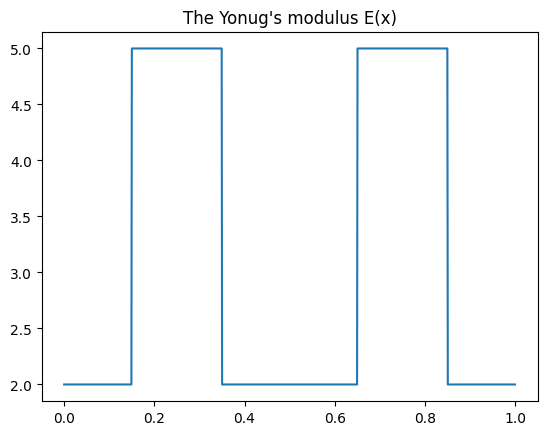

In [32]:
import numpy as np
import matplotlib.pyplot as  plt

def E(x, phase1=2., phase2=5.):
    '''Young's modulus'''
    return np.where(np.abs(x-0.5)<0.35, np.where(np.abs(x-0.5)>0.15, phase2, phase1), phase1)
#
x = np.linspace(0., 1., 1000)
e = E(x)
#
plt.figure()
plt.plot(x,e)
plt.title("The Yonug's modulus E(x)")
plt.show()

In [33]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
import h5py
from torch.autograd import grad, Variable
torch.cuda.is_available()

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Activation

        #self.activation = nn.Tanh()
        #self.activation = nn.SiLU()

        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x
#
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device) # Skalar Input, Skalar Output
from torchsummary import summary
summary(model_u, input_size=(1,), device=str(device))



Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
            Linear-2                   [-1, 40]           1,640
            Linear-3                   [-1, 40]           1,640
            Linear-4                   [-1, 40]           1,640
            Linear-5                    [-1, 1]              41
Total params: 5,041
Trainable params: 5,041
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


### Load Test Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = '/content/drive/MyDrive/Deep Learning for PDEs Final Project/archive/LinearElasticity1d.h5'
with h5py.File(filepath, 'r') as file:
    x_test = np.array(file['x_test']).reshape(-1, 1)
    u_test = np.array(file['u_test']).reshape(-1, 1)

# convert to torch Tensor
dataType = torch.float32
x_test = torch.tensor(x_test, dtype=dataType)
u_test = torch.tensor(u_test, dtype=dataType)

### Set Boundary Conditions

In [ ]:

x_bd = torch.tensor([[0.0], [1.0]], dtype=dataType) # with x element (0,1)
u_bd = torch.tensor([[0.0], [0.0]], dtype=dataType) # with u(0) = u(1) = 0
print('Size of boundary points:', x_bd.shape)


Size of boundary points: torch.Size([2, 1])


### Obtain the training data (and testing data)

In [ ]:
# The collocation points (x)
# Sample points strictly inside the domain (exclude 0 and 1)
nc = 10000
x_in = np.random.uniform(low=1e-5, high=1.0-1e-5, size=(nc,1)) # use small values for lb and ub and not 0 and 1 bc of (0,1) excluding 0 and 1
x_in = torch.tensor(x_in, dtype=dataType)
print('Size of collocation points:', x_in.shape)

Size of collocation points: torch.Size([10000, 1])


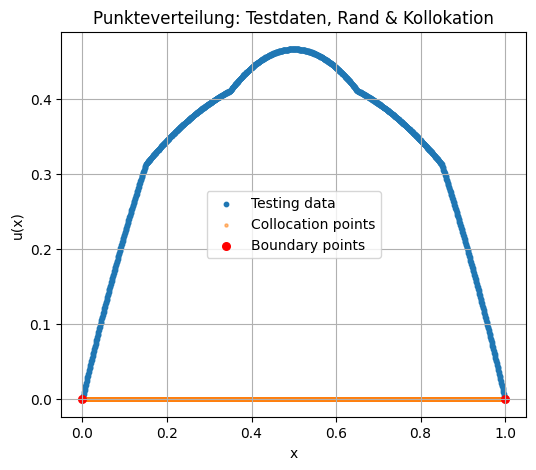

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(x_test, u_test, label='Testing data', s=10)
plt.scatter(x_in, torch.zeros_like(x_in), label='Collocation points', s=5, alpha=0.5)
plt.scatter(x_bd, u_bd, color='r', label='Boundary points', s=30)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title("Punkteverteilung: Testdaten, Rand & Kollokation")
plt.legend()
plt.grid(True)
plt.show()

### Split the test set in Test an Validation Set

In [ ]:
N = x_test.shape[0]
val_size = int(0.2 * N)


np.random.seed(42)
val_indices = np.random.choice(N, size=val_size, replace=False)
all_indices = np.arange(N)
train_indices = np.setdiff1d(all_indices, val_indices)

x_in_val = x_test[val_indices]
u_val = u_test[val_indices]

x_test = x_test[train_indices]
u_test = u_test[train_indices]

x_test.shape, x_in_val.shape, u_test.shape, u_val.shape

(torch.Size([801, 1]),
 torch.Size([200, 1]),
 torch.Size([801, 1]),
 torch.Size([200, 1]))

### Define the loss function

In [ ]:
torch.manual_seed(42)

class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
        '''
        u: Netzwerkausgabe, Tensor mit Form (N, 1)
        x: Eingabepunkte im Intervall [0,1], Tensor mit Form (N, 1)
        '''
        return u*torch.sin(torch.pi*x)

class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model
        self.getLoss = torch.nn.MSELoss()
        self.f = 9.81
        #
        self.mollifier = Mollifier(1)

    def E_x(self, x):


        dist = torch.abs(x - 0.5)
        return torch.where(
            (dist > 0.15) & (dist < 0.35),
            torch.tensor(5.0, device=x.device, dtype=x.dtype),
            torch.tensor(2.0, device=x.device, dtype=x.dtype)
        )

    def loss_pde(self, x_in):

        x = Variable(x_in, requires_grad=True).to(self.device)
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)

        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        E = self.E_x(x)

        energy = torch.mean(0.5 * E * du_dx**2 - self.f * u)
        return energy

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)

        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))






In [ ]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):

    def __init__(self,x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

train_loader = DataLoader(MyDataset(x_in), batch_size=200, shuffle=True)

In [ ]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, x, u):
        self.x = x
        self.u = u

    def __getitem__(self, index):
        return self.x[index], self.u[index]

    def __len__(self):
        return self.x.shape[0]

val_loader = DataLoader(MyDataset(x_in_val, u_val), batch_size=100, shuffle=True)

In [ ]:
from tqdm import trange
import time
############ Training setups
epochs = 1000
lr = 1e-3

model_u = MLP([1, 100, 100, 100, 100, 1], dtype=torch.float32).to(device) # Skalar Input, Skalar Output
optimizer = torch.optim.AdamW(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)

min_delta = 1e-4


error_list = []
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_weights = None
min_delta = 0.00001
early_stopping = 300

t0 = time.time()
for epoch in trange(epochs):
    model_u.train()
    total_train_loss = 0.

    for x_batch in train_loader:
        lossClass = LossClass(model_u)
        loss_train = lossClass.loss_pde(x_batch.to(device))

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        total_train_loss += loss_train.item()

    # Validation
    model_u.eval()
    total_l2_error = 0.
    for x_val, u_val in val_loader:
      x_val = x_val.to(device)
      u_val = u_val.to(device)

      u_pred = model_u(x_val)
      u_pred = lossClass.mollifier.apply(u_pred, x_val)

      l2_error = torch.sqrt(torch.sum((u_pred - u_val)**2) / torch.sum(u_val**2))
      total_l2_error += l2_error.item()

    avg_l2_error = total_l2_error / len(val_loader)
    error_list.append(avg_l2_error)

    #  early stopping
    if avg_l2_error + min_delta < best_val_loss:
        best_val_loss = avg_l2_error
        early_stopping_counter = 0
        best_model_weights = model_u.state_dict()
    else:
        early_stopping_counter += 1

    # learning rate scheduler
    scheduler.step()

    # ---------- Logging ----------
    if (epoch + 1) % 25 == 0:
        print(f"[{epoch+1}] Training Loss: {total_train_loss:.4e}, "
              f"Val Loss: {avg_l2_error:.4e}, "
              f"LR: {scheduler.optimizer.param_groups[0]['lr']:.1e}")

    if early_stopping_counter >= early_stopping:
        print(f"Early stopping triggered at epoch {epoch+1}")
        print('The consuming time is:', time.time()-t0)
        break

# laod the best model
if best_model_weights is not None:
    model_u.load_state_dict(best_model_weights)


  2%|▎         | 25/1000 [00:10<06:29,  2.50it/s]

[25] Training Loss: -7.8222e+01, Val Loss: 4.3689e-02, LR: 1.0e-03


  5%|▌         | 50/1000 [00:21<08:32,  1.85it/s]

[50] Training Loss: -7.8817e+01, Val Loss: 2.2846e-02, LR: 1.0e-03


  8%|▊         | 75/1000 [00:30<05:50,  2.64it/s]

[75] Training Loss: -7.9244e+01, Val Loss: 1.2370e-01, LR: 1.0e-03


 10%|█         | 100/1000 [00:41<05:43,  2.62it/s]

[100] Training Loss: -7.8923e+01, Val Loss: 5.5406e-02, LR: 1.0e-03


 12%|█▎        | 125/1000 [00:52<05:31,  2.64it/s]

[125] Training Loss: -7.9460e+01, Val Loss: 2.2312e-02, LR: 1.0e-03


 15%|█▌        | 150/1000 [01:03<07:01,  2.02it/s]

[150] Training Loss: -7.9521e+01, Val Loss: 7.4691e-02, LR: 1.0e-03


 18%|█▊        | 175/1000 [01:12<05:37,  2.44it/s]

[175] Training Loss: -7.9769e+01, Val Loss: 6.0826e-02, LR: 1.0e-03


 20%|██        | 200/1000 [01:24<05:16,  2.53it/s]

[200] Training Loss: -7.9865e+01, Val Loss: 6.3866e-02, LR: 1.0e-03


 22%|██▎       | 225/1000 [01:35<04:56,  2.61it/s]

[225] Training Loss: -7.9984e+01, Val Loss: 4.6677e-02, LR: 1.0e-03


 25%|██▌       | 250/1000 [01:45<04:56,  2.53it/s]

[250] Training Loss: -8.0094e+01, Val Loss: 5.5676e-02, LR: 5.0e-04


 28%|██▊       | 275/1000 [01:56<06:30,  1.86it/s]

[275] Training Loss: -8.0685e+01, Val Loss: 3.7454e-02, LR: 5.0e-04


 30%|███       | 300/1000 [02:06<04:34,  2.55it/s]

[300] Training Loss: -8.0623e+01, Val Loss: 1.6089e-02, LR: 5.0e-04


 32%|███▎      | 325/1000 [02:16<04:19,  2.60it/s]

[325] Training Loss: -8.0792e+01, Val Loss: 1.8845e-02, LR: 5.0e-04


 35%|███▌      | 350/1000 [02:27<04:17,  2.52it/s]

[350] Training Loss: -8.0780e+01, Val Loss: 3.1615e-02, LR: 5.0e-04


 38%|███▊      | 375/1000 [02:38<05:15,  1.98it/s]

[375] Training Loss: -8.0767e+01, Val Loss: 2.9051e-02, LR: 5.0e-04


 40%|████      | 400/1000 [02:48<03:54,  2.56it/s]

[400] Training Loss: -8.0617e+01, Val Loss: 1.1647e-02, LR: 5.0e-04


 42%|████▎     | 425/1000 [02:58<03:43,  2.57it/s]

[425] Training Loss: -8.0804e+01, Val Loss: 1.1335e-02, LR: 5.0e-04


 45%|████▌     | 450/1000 [03:09<03:34,  2.57it/s]

[450] Training Loss: -8.0903e+01, Val Loss: 1.6780e-02, LR: 5.0e-04


 48%|████▊     | 475/1000 [03:20<03:44,  2.34it/s]

[475] Training Loss: -8.0967e+01, Val Loss: 1.5237e-02, LR: 5.0e-04


 50%|█████     | 500/1000 [03:30<04:03,  2.05it/s]

[500] Training Loss: -8.1058e+01, Val Loss: 2.0018e-02, LR: 2.5e-04


 52%|█████▎    | 525/1000 [03:40<03:01,  2.62it/s]

[525] Training Loss: -8.1059e+01, Val Loss: 1.4018e-02, LR: 2.5e-04


 55%|█████▌    | 550/1000 [03:51<02:51,  2.63it/s]

[550] Training Loss: -8.1257e+01, Val Loss: 2.5847e-02, LR: 2.5e-04


 57%|█████▊    | 575/1000 [04:02<02:49,  2.50it/s]

[575] Training Loss: -8.1315e+01, Val Loss: 1.2071e-02, LR: 2.5e-04


 60%|██████    | 600/1000 [04:12<03:35,  1.86it/s]

[600] Training Loss: -8.1295e+01, Val Loss: 2.9441e-02, LR: 2.5e-04


 62%|██████▎   | 625/1000 [04:22<02:21,  2.65it/s]

[625] Training Loss: -8.1308e+01, Val Loss: 1.4075e-02, LR: 2.5e-04


 65%|██████▌   | 650/1000 [04:33<02:10,  2.68it/s]

[650] Training Loss: -8.1487e+01, Val Loss: 1.2449e-02, LR: 2.5e-04


 68%|██████▊   | 675/1000 [04:44<02:04,  2.61it/s]

[675] Training Loss: -8.1193e+01, Val Loss: 1.9369e-02, LR: 2.5e-04


 70%|███████   | 700/1000 [04:54<02:32,  1.97it/s]

[700] Training Loss: -8.1157e+01, Val Loss: 1.4601e-02, LR: 2.5e-04


 70%|███████   | 700/1000 [04:55<02:06,  2.37it/s]

Early stopping triggered at epoch 701
The consuming time is: 295.13673520088196



L²-relative error: 1.2986e-02


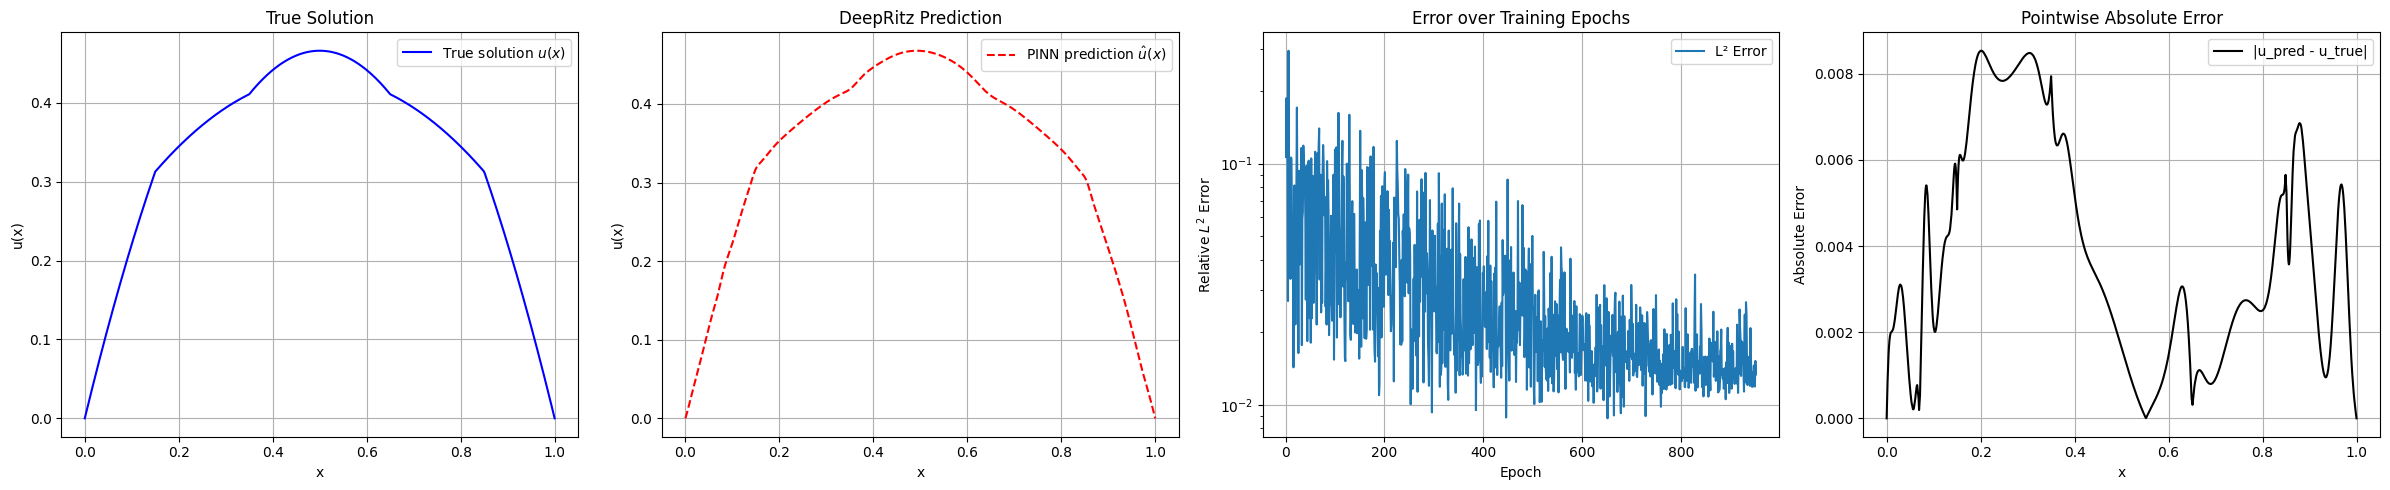

In [ ]:
model_u.load_state_dict(best_model_weights)

# Switch to evaluation mode
model_u.eval()

# Make prediction on test set
mollifier = Mollifier(1)
with torch.no_grad():
    x_plot = x_test.to(device)
    u_raw = model_u(x_plot)
    u_pred = mollifier.apply(u_raw, x_plot).cpu().numpy()
    u_true = u_test.cpu().numpy()

# Compute L^2 relative error
L2_error = np.sqrt(np.sum((u_pred - u_true)**2) / np.sum(u_true**2))
print(f"\nL²-relative error: {L2_error:.4e}")

fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Plot 1: Prediction vs True
axs[0].plot(x_test.numpy(), u_test.numpy(), 'b-', label='True solution $u(x)$')
# axs[0].plot(x_test.numpy(), u_pred, 'r--', label='PINN prediction $\hat{u}(x)$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u(x)')
axs[0].set_title('True Solution')
axs[0].legend()
axs[0].grid(True)

# Plot 1: Prediction vs True
axs[1].plot(x_test.numpy(), u_test.numpy(), 'b-', label='True solution $u(x)$')
axs[1].plot(x_test.numpy(), u_pred, 'r', label='PINN prediction $\hat{u}(x)$')
axs[1].set_xlabel('x')
axs[1].set_ylabel('u(x)')
axs[1].set_title('DeepRitz Prediction')
axs[1].legend()
axs[1].grid(True)

# Plot 2: Training error over epochs
axs[2].plot(np.arange(1, len(error_list)+1), error_list, label='L² Error')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Relative $L^2$ Error')
axs[2].set_title('Error over Training Epochs')
axs[2].set_yscale('log')
axs[2].grid(True)
axs[2].legend()

# Plot 3: Pointwise Absolute Error
abs_error = np.abs(u_pred - u_test.numpy())
axs[3].plot(x_test.numpy(), abs_error, 'k-', label='|u_pred - u_true|')
axs[3].set_xlabel('x')
axs[3].set_ylabel('Absolute Error')
axs[3].set_title('Pointwise Absolute Error')
axs[3].legend()
axs[3].grid(True)

fig.tight_layout()
plt.show()



## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>


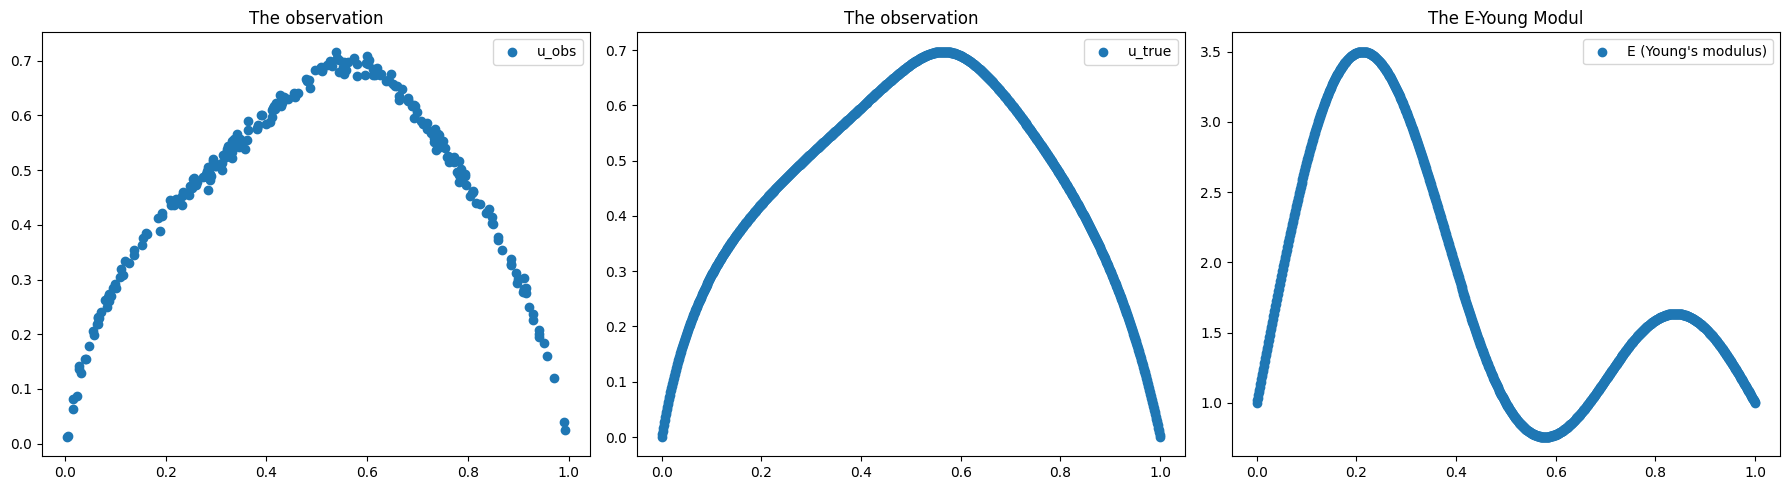

In [92]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
#

filepath = '/content/drive/MyDrive/Deep Learning for PDEs Final Project/archive/LinearElasticity1d_inverse.h5'
with h5py.File(filepath, 'r') as file:
    print(file.keys())
    #
    x_obs = np.array(file['x_obs']).reshape(-1,1)
    u_obs = np.array(file['u_obs']).reshape(-1,1)
    e_test = np.array(file['e_test']).reshape(-1,1)
    x_test = np.array(file['x_test']).reshape(-1,1)
    u_test = np.array(file['u_test']).reshape(-1,1)
#

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# plot the observation
axs[0].scatter(x_obs, u_obs, label='u_obs')
axs[0].set_title('The observation')
axs[0].legend()

# plot the observation
axs[1].scatter(x_test, u_test, label='u_true')
axs[1].set_title('The observation')
axs[1].legend()

# plot the Young module for observation purpose only
axs[2].scatter(x_test, e_test, label='E (Young\'s modulus)')
axs[2].set_title('The E-Young Modul')
axs[2].legend()

plt.tight_layout()
plt.show()


In [93]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.autograd import grad, Variable
from torch.utils.data import random_split, TensorDataset
torch.cuda.is_available()

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [94]:
x_obs = torch.tensor(x_obs, dtype=torch.float32)
u_obs = torch.tensor(u_obs, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
u_test = torch.tensor(u_test, dtype=torch.float32)
e_test = torch.tensor(e_test, dtype=torch.float32)

print('The shape of x_obs:', x_obs.shape)
print('The shape of u_obs:', u_obs.shape)

The shape of x_obs: torch.Size([250, 1])
The shape of u_obs: torch.Size([250, 1])


In [95]:
class MLP_u(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP_u, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return torch.nn.functional.silu(x)

In [96]:
model_u = MLP_u([1, 60, 60, 60, 60, 1], dtype=torch.float32).to(device) # Skalar Input, Skalar Output
from torchsummary import summary
summary(model_u, input_size=(1,), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 60]             120
            Linear-2                   [-1, 60]           3,660
            Linear-3                   [-1, 60]           3,660
            Linear-4                   [-1, 60]           3,660
            Linear-5                    [-1, 1]              61
Total params: 11,161
Trainable params: 11,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [97]:
class MLP_E(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP_E, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return torch.nn.functional.silu(x)

In [98]:
model_E = MLP_E([1, 100, 100, 100, 100, 1], dtype=torch.float32).to(device) # Skalar Input, Skalar Output
from torchsummary import summary
summary(model_E, input_size=(1,), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             200
            Linear-2                  [-1, 100]          10,100
            Linear-3                  [-1, 100]          10,100
            Linear-4                  [-1, 100]          10,100
            Linear-5                    [-1, 1]             101
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


### Create Collocation Points

In [99]:
n_col = 10000
x_in = np.random.uniform(0, 1, (n_col, 1))
x_in = torch.tensor(x_in, dtype=torch.float32)
print('Size of collocation points:', x_in.shape)

n_col_val = 1000
x_in_val = np.random.uniform(0, 1, (n_col_val, 1))
x_in_val = torch.tensor(x_in_val, dtype=torch.float32)
print('Size of collocation points:', x_in_val.shape)

Size of collocation points: torch.Size([10000, 1])
Size of collocation points: torch.Size([1000, 1])


### Set Boundary Conditions

In [100]:
x_bc = torch.tensor([[0.0], [1.0]], dtype=torch.float32)
e_bc = torch.tensor([[1.0], [1.0]], dtype=torch.float32)

In [101]:
from re import U
from torch.autograd import grad, Variable
#
torch.manual_seed(1234)
#
class Mollifier_u(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
        '''
        p: Netzwerkausgabe, Tensor mit Form (N, 1)
        x: Eingabepunkte im Intervall [0,1], Tensor mit Form (N, 1)
        '''
        return u*torch.sin(torch.pi*x)

class Mollifier_e(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, e, x):
        '''
        p: Netzwerkausgabe, Tensor mit Form (N, 1)
        x: Eingabepunkte im Intervall [0,1], Tensor mit Form (N, 1)
        '''
        return 1.0 + torch.sin(torch.pi * x)*e

class LossClass(object):

    def __init__(self, u_model, e_model):
        self.device = device
        self.u_model = u_model
        self.e_model = e_model
        self.getLoss = torch.nn.MSELoss()
        #
        self.mollifier_u = Mollifier_u(1) # one dimension
        self.mollifier_e = Mollifier_e(1) # one dimension

    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        # return torch.tensor(0.)
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        #
        u = self.u_model(x)
        u = self.mollifier_u.apply(u, x)

        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        e = self.e_model(x)
        e = self.mollifier_e.apply(e, x)

        # kx = 2.1 + torch.sin(beta[0]*x[:,0:1]) + torch.cos(beta[1]*x[:,1:2])
        #
        s = e * du_dx
        ds_dx = grad(inputs=x, outputs=s, grad_outputs=torch.ones_like(s), create_graph=True)[0]

        # The residuals
        f = 9.81 * torch.ones_like(ds_dx)
        residual = ds_dx + f
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual)) # Loss torch_zeros vector and residual (torch.zeros_like(X): creates a vetor with zeros and the shape of X)

        return loss

    def loss_data(self, x_obs, u_obs):
        '''loss term corresponds to the observation'''
        x = x_obs.to(self.device)
        u = self.u_model(x)
        u = self.mollifier_u.apply(u, x)
        #

        loss = self.getLoss(u, u_obs.to(self.device))

        return loss

    def get_error_u(self, x_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.mollifier_u.apply(u, x_test)

        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

    def get_error_e(self, x_test, e_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        e_test = e_test.to(self.device)
        e = self.e_model(x_test)
        e = self.mollifier_e.apply(e, x_test)

        return torch.sqrt(torch.sum((e-e_test)**2)/torch.sum(e_test**2))

In [102]:
print(x_in.shape)

torch.Size([10000, 1])


In [103]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):

  def __init__(self,x_in):
    self.x_in = x_in

  def __getitem__(self,index):
    return self.x_in[index]

  def __len__(self):
    return self.x_in.shape[0]


dataloader = DataLoader(MyDataset(x_in), batch_size=1000, shuffle=True)

for x_batch in dataloader:
  print('x_batch shape:',x_batch.shape)



x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])
x_batch shape: torch.Size([1000, 1])


In [107]:
from tqdm import trange
import time
############ Training setups
epochs = 2000
lr = 1e-3

optimizer = torch.optim.Adam(params=list(model_u.parameters()) + list(model_E.parameters()), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)

w_pde = 2
w_data = 1000. # 800

error_u_list, error_E_list = [],  []
t0 = time.time()
for epoch in trange(epochs):
    for x_batch in dataloader:

        model_E.train()
        model_u.train()

        lossClass = LossClass(model_u, model_E)
        loss_pde = lossClass.loss_pde(x_batch)
        loss_data = lossClass.loss_data(x_obs, u_obs)
        loss_train = w_pde * loss_pde + w_data * loss_data

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    model_u.eval()
    model_E.eval()
    #
    with torch.no_grad():
        error_u = lossClass.get_error_u(x_test, u_test)
        error_u_list.append(error_u.item())
        error_E = lossClass.get_error_e(x_test, e_test)
        error_E_list.append(error_E.item())
    scheduler.step()

    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, early stopping: lr: {scheduler.optimizer.param_groups[0]["lr"]}')
print('The consuming time is:', time.time()-t0)

  5%|▌         | 101/2000 [00:20<05:46,  5.47it/s]

Epoch:99, The loss is:0.23924848437309265, early stopping: lr: 0.001


 10%|█         | 201/2000 [00:39<05:23,  5.56it/s]

Epoch:199, The loss is:0.3905920386314392, early stopping: lr: 0.001


 15%|█▌        | 301/2000 [01:00<05:18,  5.34it/s]

Epoch:299, The loss is:0.46242743730545044, early stopping: lr: 0.001


 20%|██        | 401/2000 [01:19<04:51,  5.48it/s]

Epoch:399, The loss is:0.16207881271839142, early stopping: lr: 0.001


 25%|██▌       | 501/2000 [01:40<04:41,  5.33it/s]

Epoch:499, The loss is:0.3493860065937042, early stopping: lr: 0.0005


 30%|███       | 600/2000 [01:59<05:26,  4.29it/s]

Epoch:599, The loss is:0.10106918960809708, early stopping: lr: 0.0005


 35%|███▌      | 701/2000 [02:20<04:11,  5.16it/s]

Epoch:699, The loss is:0.1584031879901886, early stopping: lr: 0.0005


 40%|████      | 800/2000 [02:40<04:47,  4.17it/s]

Epoch:799, The loss is:0.12966811656951904, early stopping: lr: 0.0005


 45%|████▌     | 901/2000 [03:00<03:18,  5.54it/s]

Epoch:899, The loss is:0.10711080580949783, early stopping: lr: 0.0005


 50%|█████     | 1000/2000 [03:20<04:33,  3.66it/s]

Epoch:999, The loss is:0.14609262347221375, early stopping: lr: 0.00025


 55%|█████▌    | 1101/2000 [03:40<02:52,  5.22it/s]

Epoch:1099, The loss is:0.09590790420770645, early stopping: lr: 0.00025


 60%|██████    | 1201/2000 [04:01<02:34,  5.16it/s]

Epoch:1199, The loss is:0.16610336303710938, early stopping: lr: 0.00025


 65%|██████▌   | 1301/2000 [04:20<02:06,  5.53it/s]

Epoch:1299, The loss is:0.09580348432064056, early stopping: lr: 0.00025


 70%|███████   | 1401/2000 [04:41<01:53,  5.28it/s]

Epoch:1399, The loss is:0.1156633049249649, early stopping: lr: 0.00025


 75%|███████▌  | 1501/2000 [05:01<01:38,  5.06it/s]

Epoch:1499, The loss is:0.09545732289552689, early stopping: lr: 0.000125


 80%|████████  | 1601/2000 [05:23<01:20,  4.98it/s]

Epoch:1599, The loss is:0.09410352259874344, early stopping: lr: 0.000125


 85%|████████▌ | 1700/2000 [05:44<01:12,  4.13it/s]

Epoch:1699, The loss is:0.09410058706998825, early stopping: lr: 0.000125


 90%|█████████ | 1801/2000 [06:04<00:36,  5.48it/s]

Epoch:1799, The loss is:0.09403125196695328, early stopping: lr: 0.000125


 95%|█████████▌| 1901/2000 [06:25<00:22,  4.44it/s]

Epoch:1899, The loss is:0.0942675918340683, early stopping: lr: 0.000125


100%|██████████| 2000/2000 [06:44<00:00,  4.94it/s]

Epoch:1999, The loss is:0.0940675288438797, early stopping: lr: 6.25e-05
The consuming time is: 404.7140610218048


In [108]:
# prediction
mollifier_u = Mollifier_u(1)
mollifier_e = Mollifier_e(1)

x_test = x_test.to(device)

with torch.no_grad(): # or detach()
  u_pred = model_u(x_test).to(device)
  u_pred = mollifier_u.apply(u_pred, x_test).to(device)
  E_pred = model_E(x_test).to(device)
  E_pred = mollifier_e.apply(E_pred, x_test).to(device)

u_pred = u_pred.cpu().numpy()
E_pred = E_pred.cpu().numpy()

print('Shape of u_pred:', u_pred.shape)
print('Shape of E_pred:', E_pred.shape)
print('Shape of x_plot:', x_test.shape)

Shape of u_pred: (1001, 1)
Shape of E_pred: (1001, 1)
Shape of x_plot: torch.Size([1001, 1])



L²-relative error: 3.6086e-02

L²-relative error: 3.9383e-03


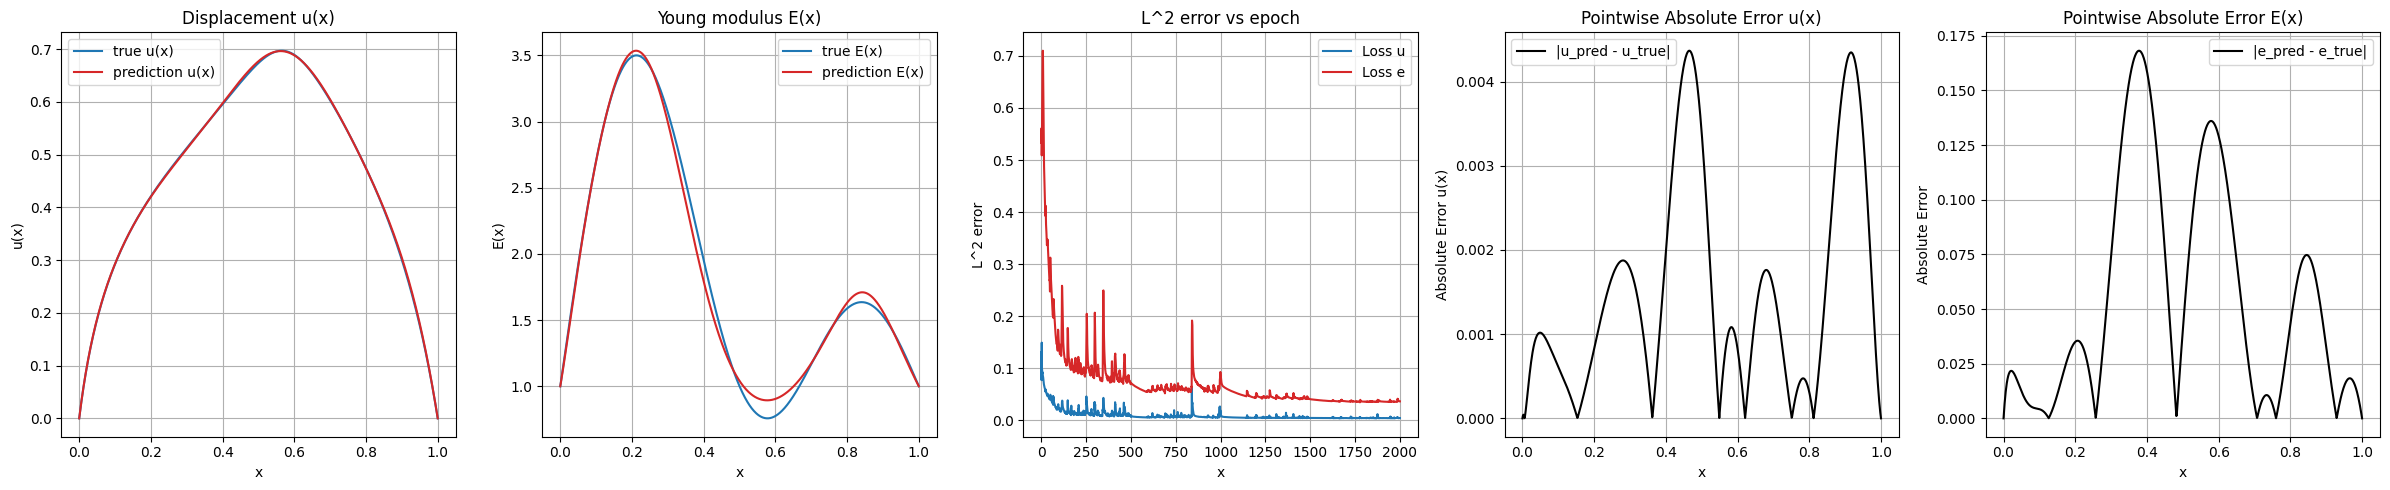

In [113]:
# Compute L^2 relative error
L2_error = np.sqrt(np.sum((E_pred - e_test.numpy())**2) / np.sum(e_test.numpy()**2))
print(f"\nL²-relative error: {L2_error:.4e}")

L2_error = np.sqrt(np.sum((u_pred - u_test.numpy())**2) / np.sum(u_test.numpy()**2))
print(f"\nL²-relative error: {L2_error:.4e}")

# Create th plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,5))

x_test = x_test.cpu()

# Plot u(x)
axes[0].plot(x_test, u_test, label='true u(x)', color='tab:blue')
axes[0].plot(x_test, u_pred, label='prediction u(x)', color='tab:red')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x)')
axes[0].set_title('Displacement u(x)')
axes[0].grid(True)
axes[0].legend()

# Plot E(x)
axes[1].plot(x_test, e_test, label='true E(x)', color='tab:blue')
axes[1].plot(x_test, E_pred, label='prediction E(x)', color='tab:red')
axes[1].set_xlabel('x')
axes[1].set_ylabel('E(x)')
axes[1].set_title('Young modulus E(x)')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(np.arange(1, epoch+2), error_u_list, label='Loss u', color='tab:blue')
axes[2].plot(np.arange(1, epoch+2), error_E_list, label='Loss e', color='tab:red')
axes[2].set_xlabel('x')
axes[2].set_ylabel('L^2 error')
axes[2].set_title('L^2 error vs epoch')
axes[2].grid(True)
axes[2].legend()

# Plot 3: Pointwise Absolute Error
abs_error = np.abs(u_pred - u_test.numpy())
axes[3].plot(x_test.numpy(), abs_error, 'k-', label='|u_pred - u_true|')
axes[3].set_xlabel('x')
axes[3].set_ylabel('Absolute Error u(x)')
axes[3].set_title('Pointwise Absolute Error u(x)')
axes[3].legend()
axes[3].grid(True)

# Plot 3: Pointwise Absolute Error
abs_error = np.abs(E_pred - e_test.numpy())
axes[4].plot(x_test.numpy(), abs_error, 'k-', label='|e_pred - e_true|')
axes[4].set_xlabel('x')
axes[4].set_ylabel('Absolute Error')
axes[4].set_title('Pointwise Absolute Error E(x)')
axes[4].legend()
axes[4].grid(True)

fig.tight_layout()
plt.show()


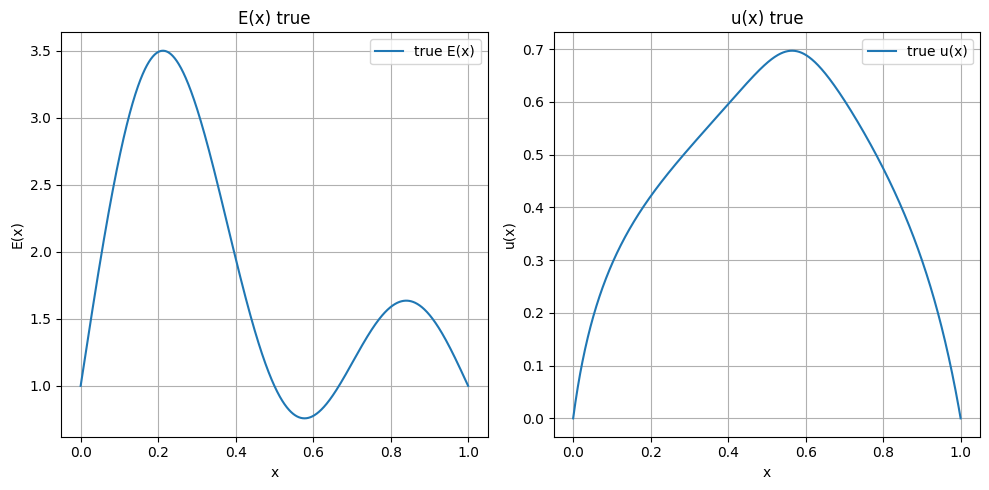

In [110]:
# Create th plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot 3: Plot e test
axes[0].plot(x_test, e_test, label='true E(x)', color='tab:blue')
axes[0].set_xlabel('x')
axes[0].set_ylabel('E(x)')
axes[0].set_title('E(x) true')
axes[0].legend()
axes[0].grid(True)

# Plot 3: Plot u test
axes[1].plot(x_test, u_test, label='true u(x)', color='tab:blue')
axes[1].set_xlabel('x')
axes[1].set_ylabel('u(x)')
axes[1].set_title('u(x) true')
axes[1].legend()
axes[1].grid(True)


fig.tight_layout()
plt.show()